# Loading data and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
# timedelta : 파이썬에서 날짜와 시간 간격을 다루기 위한 라이브러리
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os
import tensorflow as tf

In [2]:
# parse_dates는 pandas의 read_csv 함수의 옵션 중 하나로, 날짜 형식의 열을 자동으로 파싱하도록 지정합니다.
# 이 옵션을 사용하여 CSV 파일을 읽을 때 날짜 열을 자동으로 파싱하도록 할 수 있습니다.
df_holidays = pd.read_csv('data/holidays_events.csv', encoding = 'cp949', header = 0, parse_dates = ['date'])
df_oil = pd.read_csv("data/oil.csv", encoding = 'cp949', header = 0, parse_dates = ['date'])
df_stores = pd.read_csv("data/stores.csv", encoding = 'cp949', header = 0)
df_trans = pd.read_csv("data/transactions.csv", encoding = 'cp949', header = 0, parse_dates = ['date'])

df_train = pd.read_csv("data/train.csv", encoding = "cp949", header = 0, parse_dates = ['date'])
df_test = pd.read_csv("data/test.csv", encoding = "cp949", header = 0, parse_dates = ['date'])

In [3]:
li = [df_holidays, df_oil, df_stores, df_trans, df_train, df_test]

for i in range(len(li)):
    if 'sales' in li[i].columns:
        li[i].rename(columns = {'sales': 'y'}, inplace = True)
    if 'date' in li[i].columns:
        li[i].rename(columns = {'date' : 'ds'}, inplace = True) # 'ds'는 'datestamp'를 줄인 것으로, 주로 시계열 데이터에서 날짜를 나타내는 열 이름으로 사용됩니다.

In [4]:
def rmsle(y_hat, y):
    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y)))) ** 2) / len(y))
    return round(metric, 4)

# Utils

In [5]:
class WindowGenerator():
    '''
    TensorFlow의 WindowGenerator 클래스를 정의하는 코드입니다.
    이 클래스는 시계열 데이터를 입력받아,
    입력 시퀀스와 레이블 시퀀스를 처리하고 모델링에 필요한 형태로 변환하는 클래스입니다.
    '''
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns = None):
        '''
        input_width : 입력 시퀀스의 길이를 나타내는 정수입니다.
        label_width : 레이블 시퀀스의 길이를 나타내는 정수입니다.
        shift : 레이블 시퀀스가 시작되는 시점을 나타내는 정수입니다.
        train_df, val_df, test_df : 각각 훈련, 검증, 테스트 데이터셋을 나타내는 Pandas DataFrame입니다.
        label_columns : 레이블 데이터의 컬럼 이름을 나타내는 리스트입니다.
        '''
        # 원시 데이터를 저장합니다.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # 레이블 열 인덱스를 작성합니다.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Window 매개변수를 계산합니다.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift # 어느 기간 단위로 끊어서 보고 싶은지

        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width # label_start 이후의 데이터는 예측 대상이 아니며, 실제 레이블과 비교하기 위해 사용되는 값입니다.
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
        
    def split_window(self, features):
        '''
        이 메소드는 “WindowGenerator” 클래스 내에서 정의된 인풋 및 라벨 슬라이스를 이용하여 
        시계열 데이터를 인풋 데이터와 라벨 데이터로 분리하는 역할을 합니다.
        '''
        # 시계열 데이터를 나타내는 3차원 배열의 구조는 (배치 크기, 시간 단계, 피쳐 수)입니다.
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
                # 결과적으로 labels는 (batch_size, label_width, num_label_columns) 형태의 3D 텐서가 됩니다.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        # slicing 작업은 shape 정보를 유지하지 않기 때문에, set_shape() 함수를 사용하여 shape 정보를 수동으로 설정합니다.
        # 이렇게 하면 tf.data.Datasets를 더 쉽게 검사할 수 있습니다.
        return inputs, labels        

        
    def plot(self, model = None, plot_col = 'sales', max_subplots = 3):
        inputs, labels = self.example
        plt.figure(figsize = (12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col}[normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label = 'Inputs', marker = '.', zorder = -10)
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors = 'k', label = 'Labels', c = '#2ca02c', s = 64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker = 'X', edgecolors = 'k', label = 'Predictions', c = '#ff7f0e', s = 64)
            
            if n == 0:
                plt.legend()
        
            plt.xlabel('Days')
            
    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data = data, targets = None, sequence_length = self.total_window_size,
                                                        sequence_stride = 1, shuffle = True, batch_size = 32, )
        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """ Get and cache an example batch of 'inputs, labels' for plotting. """
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the '.train' dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
        

In [6]:
def compile_and_fit(model, window, max_epochs, learning_rate):
    '''
    모델을 컴파일하고 주어진 데이터로 모델을 학습시키는 함수입니다.
    '''
    # 컴파일 설정
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    # 학습
    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val)

    return history


In [7]:
def get_last_available_week(df):
    # 사용 가능한 마지막 주 날짜 가져오기
    df = df.assign(diff_from_max_train_ds = df.ds - (df.ds.min() - timedelta(days = 1))) # -datetime.strptime(df.ds.min(), "%Y-%m-%d")
    df = df.assign(nb_weeks = np.ceil(df.diff_from_max_train_ds.dt.days / 7).astype('int'))
    df = df.assign(last_week_ds = df.ds - (df.nb_weeks * 7).map(lambda x: timedelta(x)))
    
    return df

In [8]:
def get_yhat(df):
    df = pd.merge(df,
                  df[['ds', 'store_nbr', 'family', 'prop_family_per_store']].rename(columns = {'prop_family_per_store' : 'last_week_prop_family_per_store'}),
                  left_on = ['last_week_ds', 'store_nbr', 'family'],
                  right_on = ['ds', 'store_nbr', 'family'],
                  how = 'left').drop(['diff_from_max_train_ds', 'nb_weeks', 'last_week_ds', 'ds_y'], axis = 1).rename(columns = {'ds_x': 'ds'})
    
    df = df.assign(yhat = df.yhat_store_nbr * df.last_week_prop_family_per_store)

    return df

In [9]:
train_df, test_df = df_train.copy(), df_test.copy()

# Cross validation
val_df = train_df[(train_df.ds >= '2017-08-01') & (train_df.ds <= '2017-08-15')]

val_df = pd.merge(get_last_available_week(val_df)[['id', 'ds', 'last_week_ds', 'store_nbr', 'family', 'y']],
                  train_df[['ds', 'store_nbr', 'family', 'y']],
                  left_on = ['last_week_ds', 'store_nbr', 'family'], right_on = ['ds', 'store_nbr', 'family'], how = 'left').rename(columns = {'ds_x': 'ds', 'y_x': 'y', 'y_y': 'yhat'})

print('RMSLE: %s'% rmsle(val_df.yhat, val_df.y))

RMSLE: 0.6124


In [10]:
submission_df = pd.merge(get_last_available_week(test_df)[['id', 'ds', 'last_week_ds', 'store_nbr', 'family']],
                         train_df[['ds', 'store_nbr', 'family', 'y']],
                         left_on = ['last_week_ds', 'store_nbr', 'family'], right_on = ['ds', 'store_nbr', 'family'], how = 'left')[['id', 'y']].rename(columns = {'y': 'sales'})

# submission_df.to_csv('submission.csv', index = False)

# LSTM

## Training

In [11]:
train = WindowGenerator.train
val = WindowGenerator.val
test = WindowGenerator.test
example = WindowGenerator.example
make_dataset = WindowGenerator.make_dataset
split_window = WindowGenerator.split_window
plot = WindowGenerator.plot

In [12]:
# Parameters
start_training_ds = '2017-01-01'
input_width = 1 * 7
label_width = 16

MAX_EPOCHS = 50
learning_rate = 0.001
scaling = ['standardisation', 'normalisation'][0]

# dataframe reshape
df = df_train[df_train.ds >= start_training_ds].assign(key = df_train['store_nbr'].astype('str') + '~' + df_train['family'])
df = pd.pivot_table(df, values = 'y', index = ['ds'], columns = 'key').reset_index()
date_time = df.ds
df = df.drop('ds', axis = 1)
df = df.iloc[:, :df.shape[1]]
column_indices = {name: i for i, name in enumerate(df.columns)}

# train, val, test split
n = len(df)
test_df = df[-label_width:]
val_df = df[-(input_width + 2 * label_width):-label_width]
train_df = df[:-(input_width + label_width)]

print("Train set size: (%s, %s)"%(train_df.shape[0], train_df.shape[1]))
print("Validation set size: (%s, %s)"%(test_df.shape[0], test_df.shape[1]))
print("Test set size: (%s, %s) \n"%(val_df.shape[0], val_df.shape[1]))

num_features = df.shape[1]

# 정규화
if scaling == 'standardisation':
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    train_df = train_df.fillna(0)
    val_df = (val_df - train_mean) / train_std
    val_df = val_df.fillna(0)
    test_df = (test_df - train_mean) / train_std
    test_df = test_df.fillna(0)

    train_df[train_df == np.inf] = 0
    val_df[val_df == np.inf] = 0
    test_df[test_df == np.inf] = 0

elif scaling == 'normalisation':
    scaler = MinMaxScaler(feature_range = (0, 1))
    train_df = pd.DataFrame(scaler.fit_transform(train_df), columns = train_df.columns)
    val_df = pd.DataFrame(scaler.transform(val_df), columns = val_df.columns)
    test_df = pd.DataFrame(scaler.transform(test_df), columns = test_df.columns)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.make_dataset = make_dataset
WindowGenerator.split_window = split_window
WindowGenerator.plot = plot

# Generate windows for training batches
window = WindowGenerator(input_width = input_width, label_width = label_width, shift = label_width, train_df = train_df, val_df = val_df, test_df = test_df)

model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.Conv1D(filters = 128, kernel_size = (input_width,), activation = 'relu'),
    tf.keras.layers.LSTM(128, return_sequences = False),
    tf.keras.layers.Dense(label_width * num_features, kernel_initializer = tf.initializers.zeros()),
    tf.keras.layers.Reshape([label_width, num_features])
])

print('Input shape:', window.example[0].shape)
print('Labels shape:', window.example[1].shape)
print('Output shape:', model(window.example[0]).shape)

history = compile_and_fit(model, window, MAX_EPOCHS, learning_rate)

Train set size: (204, 1782)
Validation set size: (16, 1782)
Test set size: (23, 1782) 

Input shape: (32, 7, 1782)
Labels shape: (32, 16, 1782)
Output shape: (32, 16, 1782)
Epoch 1/50
6/6 [==============================] - 4s 182ms/step - loss: 0.9126 - mean_absolute_error: 0.6962 - val_loss: 1.8047 - val_mean_absolute_error: 0.6959
Epoch 2/50
6/6 [==============================] - 0s 67ms/step - loss: 0.8524 - mean_absolute_error: 0.6670 - val_loss: 1.7097 - val_mean_absolute_error: 0.6493
Epoch 3/50
6/6 [==============================] - 0s 63ms/step - loss: 0.7712 - mean_absolute_error: 0.6257 - val_loss: 1.6586 - val_mean_absolute_error: 0.6239
Epoch 4/50
6/6 [==============================] - 0s 68ms/step - loss: 0.7275 - mean_absolute_error: 0.6027 - val_loss: 1.6410 - val_mean_absolute_error: 0.6152
Epoch 5/50
6/6 [==============================] - 0s 73ms/step - loss: 0.7005 - mean_absolute_error: 0.5883 - val_loss: 1.6316 - val_mean_absolute_error: 0.6090
Epoch 6/50
6/6 [=====

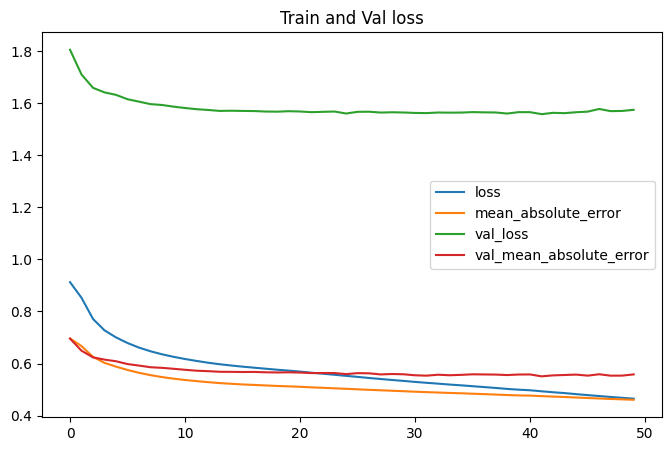

In [13]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.title('Train and Val loss')
plt.show()

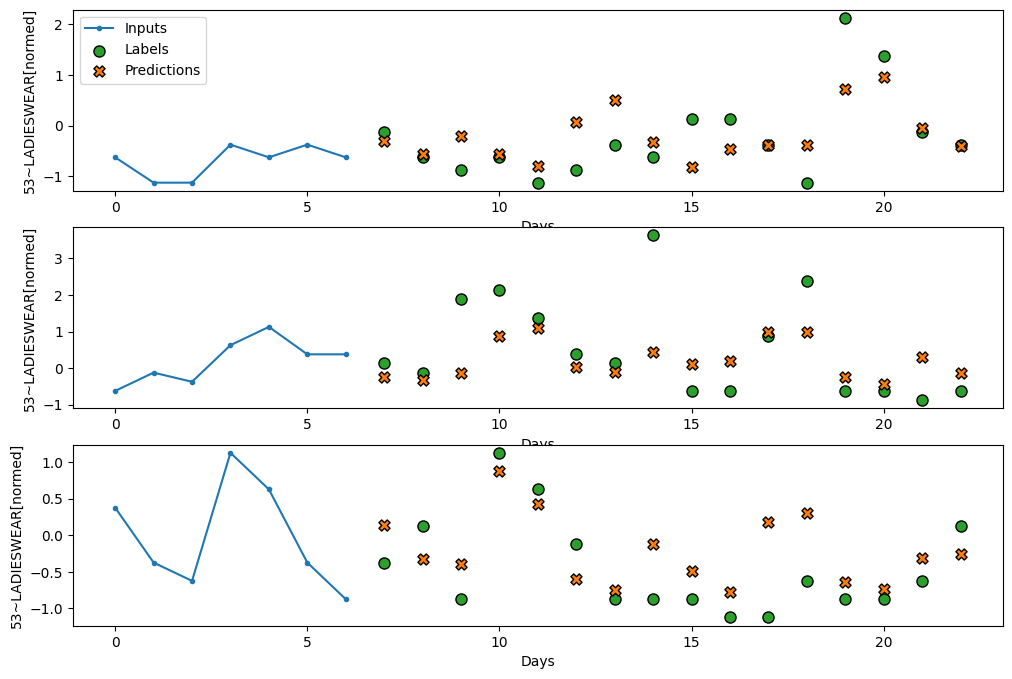

In [14]:
window.plot(model, plot_col = random.choice(train_df.columns))

## Cross Validation

In [15]:
# 유효성 검사 기간의 마지막 값을 사용하여 테스트 기간에 대한 예측을 생성합니다.
y_hat = model.predict(val_df.values[-input_width:, :].reshape(1, input_width, num_features))
predict_df = (pd.DataFrame(y_hat.reshape(label_width, num_features), columns=df.columns)*train_std + train_mean).assign(ds=date_time[-label_width:].values)
columns_to_keep = [e for e in predict_df.columns if '~' in e or e == 'ds'] 
predict_df = predict_df[columns_to_keep]
predict_df = predict_df.melt(id_vars =['ds'], value_vars =[c for c in predict_df.columns if c != 'ds'])
predict_df[['store_nbr', 'family']] = predict_df.key.str.split('~', expand=True)
predict_df = predict_df.rename(columns={'value': 'y_hat'})
predict_df['store_nbr'] = predict_df.store_nbr.astype('int')
predict_df.drop('key', axis=1, inplace=True)

predict_df = pd.merge(df_train.drop('id', axis=1), predict_df, on=['ds', 'store_nbr', 'family'], how='left')
predict_df['y_hat'] = np.clip(predict_df.y_hat, 0, np.inf)

predict_df.tail()

1/1 [==============================] - 0s 474ms/step


,ds,store_nbr,family,y,onpromotion,y_hat
3000883,2017-08-15,9,POULTRY,438.133,0,370.266666
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,116.634480
3000885,2017-08-15,9,PRODUCE,2419.729,148,2347.012650
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2.471955
3000887,2017-08-15,9,SEAFOOD,16.000,0,15.664490


In [16]:
predict_df['error'] = (np.log(1 + predict_df[~predict_df.y_hat.isnull()].y) - np.log(1 + predict_df[~predict_df.y_hat.isnull()].y_hat))**2
print("RMSLE: %s" %rmsle(predict_df[~predict_df.y_hat.isnull()].y, predict_df[~predict_df.y_hat.isnull()].y_hat))

RMSLE: 0.5469


##  Investigation

In [17]:
predict_df['key'] = predict_df['store_nbr'].astype(str) + '~' + predict_df['family'].astype(str)
rmsle_per_ts_df = predict_df.groupby('key').agg({'error': 'sum'}).sort_values('error', ascending=False).reset_index()
rmsle_per_ts_df.head(10)

,key,error
0,45~SCHOOL AND OFFICE SUPPLIES,334.221364
1,50~SCHOOL AND OFFICE SUPPLIES,303.980694
2,47~SCHOOL AND OFFICE SUPPLIES,298.621339
3,46~SCHOOL AND OFFICE SUPPLIES,289.998331
4,48~SCHOOL AND OFFICE SUPPLIES,279.605726
5,49~SCHOOL AND OFFICE SUPPLIES,279.178062
6,44~SCHOOL AND OFFICE SUPPLIES,218.818111
7,9~SCHOOL AND OFFICE SUPPLIES,200.323942
8,20~SCHOOL AND OFFICE SUPPLIES,150.864995
9,18~SCHOOL AND OFFICE SUPPLIES,109.021369


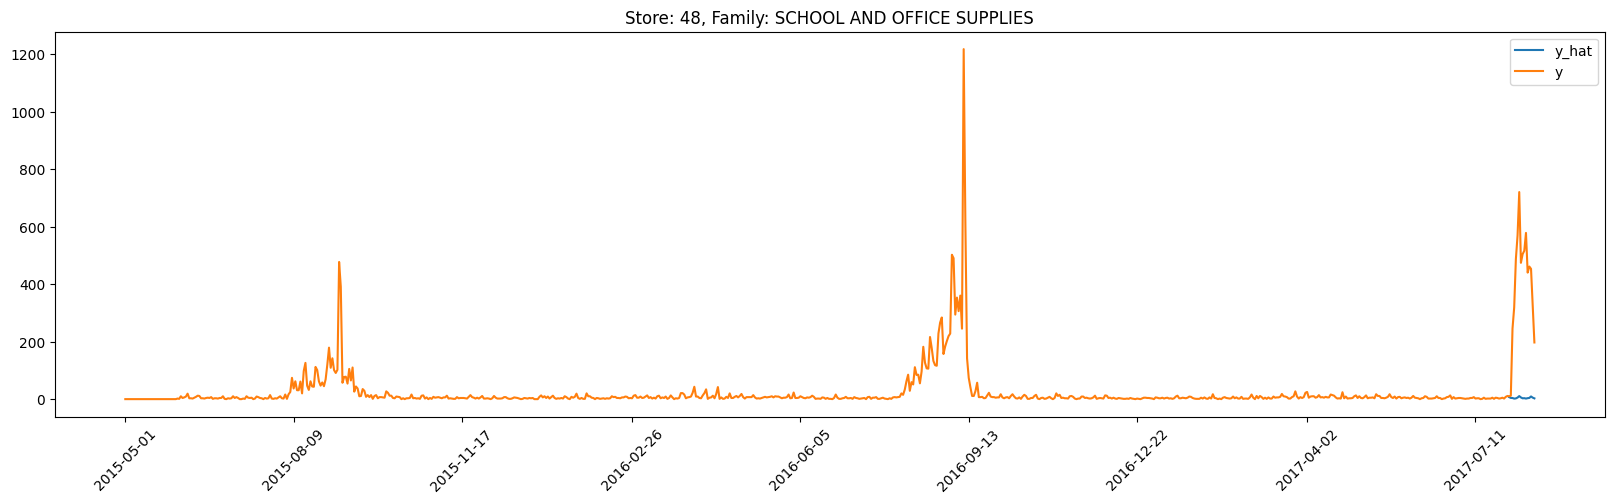

In [18]:
plot_ds_range = ['2015-05-01', predict_df.ds.iloc[-1]]
fig, ax = plt.subplots(figsize=(20, 5))
unique_keys = set(zip(df_train.store_nbr, df_train.family))
key = random.choice(list(unique_keys))
key = [48, 'SCHOOL AND OFFICE SUPPLIES']
ts = predict_df[(predict_df.store_nbr == key[0]) & (predict_df.family == key[1])]
ts = ts[(ts.ds >= plot_ds_range[0]) & (ts.ds <= plot_ds_range[1])]

# plt.plot(ts.ds, ts.onpromotion*np.median(ts.y), label='promotion')
plt.plot(ts.ds, ts.y_hat, label='y_hat')
plt.plot(ts.ds, ts.y, label='y')
plt.title("Store: " + str(key[0]) + ", Family: " + key[1])
plt.legend()
ax.set_xticks(np.array(ts.ds)[::100])
ax.tick_params(axis='x',rotation=45)
plt.show()